In [1]:
%load_ext autoreload
%autoreload 2

import os, json, pickle
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import matplotlib.pyplot as plt

import go_bench
from go_bench.load_tools import load_GO_tsv_file, load_protein_sequences, convert_to_sparse_matrix

from go_metric.data_utils import *
from go_metric.models.bottleneck_dpg_conv import DPGModule
from scipy.sparse import csr_matrix, csc_matrix, dok_matrix, vstack, hstack
from sklearn.metrics import precision_recall_fscore_support

# device = torch.device('cuda:0')
def get_sparse_probs(model, dataloader, threshold=0.02):
    prot_ids = []
    probs_list = []
    with torch.no_grad():
        for d in dataloader:
            prot_id_l = d["prot_id"]
            X = d["seq"]
            prot_ids.extend(prot_id_l)
            X = X.to(model.device)
            m_probs = model(X)
            torch.sigmoid(m_probs, out=m_probs)
            m_probs = m_probs.cpu().numpy()
            m_probs = np.where(m_probs > threshold, m_probs, 0) #Threshold unlikely predictions to keep output sparse. 
            new_probs = csr_matrix(m_probs, dtype=np.float32)
            probs_list.append(new_probs)
    probs = vstack(probs_list)
    return prot_ids, probs

from sklearn.metrics import multilabel_confusion_matrix, precision_recall_fscore_support
from go_bench.metrics import threshold_stats

def load_diamond_scores(hit_fn):
    diamond_scores = {}
    with open(hit_fn) as f:
        for line in f:
            it = line.strip().split()
            if it[0] not in diamond_scores:
                diamond_scores[it[0]] = {}
            diamond_scores[it[0]][it[1]] = float(it[2])
    return diamond_scores

def blast_hit_to_pred(train_dict, diamond_scores, pred_ids):
    blast_preds = {}
    for prot_id in pred_ids:
        annots = {}
        if(prot_id in diamond_scores):
            sim_prots = diamond_scores[prot_id] #Similar prots in training
            allgos = set()
            total_score = 0.0
            for pid, score in sim_prots.items():
                allgos |= set(train_dict[pid]) #GO Terms for each similar prot
                total_score += score
            allgos = list(sorted(allgos))
            sim = np.zeros(len(allgos), dtype=np.float32)
            for j, go_id in enumerate(allgos):
                s = 0.0
                for p_id, score in sim_prots.items():
                    if go_id in train_dict[p_id]:
                        s += score
                sim[j] = s / total_score
            for go_id, score in zip(allgos, sim):
                annots[go_id] = score
        blast_preds[prot_id] = annots
    return blast_preds

from scipy.sparse import csr_matrix, dok_matrix, lil_matrix
def score_dict_to_sparse_matrix(protein_annotation_dict, term_list, prot_id_list):
    term_col_mappings = {term:i for i, term in enumerate(term_list)}
    prot_row_mappings = {prot:i for i, prot in enumerate(prot_id_list)}

    labels = lil_matrix((len(prot_id_list), len(term_list)), dtype=np.float64)

    for row, prot_id in enumerate(prot_id_list):
        if(prot_id in protein_annotation_dict):
            for go_id, score in protein_annotation_dict[prot_id].items():
                if(go_id in term_col_mappings):
                    labels[row, term_col_mappings[go_id]] = score
    labels = labels.tocsr()
    return labels

from collections import defaultdict
def sparse_matrix_to_score_dict(pred_matrix, term_list, prot_id_list):
    protein_annotation_dict = defaultdict(dict)
    for row, prot_id in enumerate(prot_id_list):
        pr = pred_matrix[row]
        for go_index, score in zip(pr.indices, pr.data):
            protein_annotation_dict[prot_id][term_list[go_index]] = score
    return protein_annotation_dict

def load_annot_matrix(term_path, annot_path, seq_path):
    with open(term_path, 'r') as f:
        go_terms = json.load(f)
    annot_dict = load_GO_tsv_file(annot_path)
    dict_ids = list(annot_dict.keys())
    annot_seqs, annot_ids = load_protein_sequences(seq_path, set(dict_ids))
    annot_mat = convert_to_sparse_matrix(annot_dict, go_terms, annot_ids)
    return go_terms, annot_ids, annot_seqs, annot_mat

In [2]:
go_terms, train_ids, _, train_labels = load_annot_matrix("data/go_bench/molecular_function_terms.json", 
                                                        "data/go_bench/training_molecular_function_annotations.tsv",
                                                        "data/uniprot_reviewed.fasta")

_, val_ids, _, val_labels = load_annot_matrix("data/go_bench/molecular_function_terms.json", 
                                                        "data/go_bench/validation_molecular_function_annotations.tsv",
                                                        "data/uniprot_reviewed.fasta")

test_go_terms, test_ids, _, test_labels = load_annot_matrix("data/go_bench/molecular_function_terms.json", 
                                                        "data/go_bench/testing_molecular_function_annotations.tsv",
                                                        "data/uniprot_reviewed.fasta")

In [3]:
import numpy as np
import json, torch
from torch.utils.data import DataLoader
from go_metric.data_utils import *
from go_metric.models.bottleneck_dpg_conv import DPGModule
train_path = "/home/andrew/go_metric/data/go_bench"

train_dataset = BertSeqDataset.from_pickle(f"{train_path}/train.pkl")
val_dataset = BertSeqDataset.from_pickle(f"{train_path}/val.pkl")
test_dataset = BertSeqDataset.from_pickle(f"{train_path}/test.pkl")

In [4]:
with open("/home/andrew/GO_benchmarking/ia_dict.json", "r") as f:
    ia_dict = {int(x): float(y) for x, y in json.load(f).items()}
# from qtlsearch.OBOParser import OBO
# go = OBO('/home/andrew/GO_benchmarking/data/go.obo.gz', store_as_int=True)
test_ia = np.zeros(len(test_go_terms))
for i, test_id in enumerate(test_go_terms):
    id_int = int(test_id[3:])
    if(id_int in ia_dict):
        test_ia[i] = ia_dict[id_int]

In [ ]:
# ep = 'pretrained_esm'
# with open(f"emb/{ep}_train_emb.pkl", "rb") as f:
#     pkl_emb = pickle.load(f)
#     train_ids, train_embeddings = pkl_emb['prot_id'], pkl_emb['embeddings']
#     preesm_train_dict = {"prot_id": train_ids, "embedding": train_embeddings}
# with open(f"emb/{ep}_test_emb.pkl", "rb") as f:
#     pkl_emb = pickle.load(f)
#     test_ids, test_embeddings = pkl_emb['prot_id'], pkl_emb['embeddings']
#     preesm_test_dict = {"prot_id": test_ids, "embedding": test_embeddings}
# with open(f"emb/{ep}_train_emb.pkl", "wb") as f:
#     pickle.dump(preesm_train_dict, f)
    
# with open(f"emb/{ep}_test_emb.pkl", "wb") as f:
#     pickle.dump(preesm_test_dict, f)

In [6]:
embedding_paths = ['conv128', 'conv2048', 'rostlab', 'finetune', 'pretrained_esm', 'esm_finetune']
emb_dict = {}
for ep in embedding_paths:
    print(ep)
    with open(f"emb/{ep}_train_emb.pkl", "rb") as f:
        pkl_emb = pickle.load(f)
        train_ids, train_embeddings = pkl_emb['prot_id'], pkl_emb['embedding']
        # print(all(p1 == p2 for p1, p2 in zip(train_dataset.prot_names, train_ids)))
    if(not ep in ['pretrained_esm', 'esm_finetune']):
        with open(f"emb/{ep}_val_emb.pkl", "rb") as f:
            pkl_emb = pickle.load(f)
            val_ids, val_embeddings = pkl_emb['prot_id'], pkl_emb['embedding']
        # print(all(p1 == p2 for p1, p2 in zip(val_dataset.prot_names, val_ids)))
    with open(f"emb/{ep}_test_emb.pkl", "rb") as f:
        pkl_emb = pickle.load(f)
        test_ids, test_embeddings = pkl_emb['prot_id'], pkl_emb['embedding']
    emb_dict[ep] = ((train_ids, train_embeddings), (val_ids, val_embeddings), (test_ids, test_embeddings))

conv128
conv2048
rostlab
finetune
pretrained_esm
esm_finetune


In [12]:
from go_metric.multilabel_knn import pd_knn, pd_wknn, euclid_dist, cos_dist
train_labels = train_dataset.labels.toarray()
val_labels = val_dataset.labels.toarray()
test_labels = test_dataset.labels.toarray()

cos_knn_emb_stats = {}
for ep, embs in emb_dict.items():
    te, ve, tee = embs
    train_ids, train_emb = te
    test_ids, test_emb = tee
    k_perf = []
    distances, neighbors = cos_dist(train_emb, test_emb, max_k=15)
    for k in range(1, 15):
        knn_preds = pd_knn(distances, neighbors, train_labels, k=k) > 0.5
        p, r, f, support = precision_recall_fscore_support(test_labels, knn_preds, average='micro')
        k_perf.append(f)
    cos_knn_emb_stats[ep] = k_perf

wknn_emb_stats = {}
for ep, embs in emb_dict.items():
    te, ve, tee = embs
    train_ids, train_emb = te
    test_ids, test_emb = tee
    k_perf = []
    distances, neighbors = euclid_dist(train_emb, test_emb, max_k=15)
    for k in range(1, 15):
        knn_preds = pd_wknn(distances, neighbors, train_labels, k=k) > 0.5
        p, r, f, support = precision_recall_fscore_support(test_labels, knn_preds, average='micro')
        k_perf.append(f)
    wknn_emb_stats[ep] = k_perf

knn_emb_stats = {}
for ep, embs in emb_dict.items():
    te, ve, tee = embs
    train_ids, train_emb = te
    test_ids, test_emb = tee
    k_perf = []
    distances, neighbors = euclid_dist(train_emb, test_emb, max_k=15)
    for k in range(1, 15):
        knn_preds = pd_knn(distances, neighbors, train_labels, k=k) > 0.5
        p, r, f, support = precision_recall_fscore_support(test_labels, knn_preds, average='micro')
        k_perf.append(f)
    knn_emb_stats[ep] = k_perf

In [ ]:
import seaborn as sns
sns.set_theme()
sns.set(font_scale=0.8)
colors = sns.color_palette()

embedding_paths = ['conv128', 'conv2048', 'rostlab', 'finetune', 'pretrained_esm', 'esm_finetune']
model_labels = ['Conv128', 'Conv2048', 'BERT-Emb', 'BERT-FT-Emb', 'ESM-Emb', 'ESM-FT-Emb']
label_info = {ep: l for ep, l in zip(embedding_paths, model_labels)}

disp_info = {
    "BLAST": colors[0],
    "Conv128": colors[1],
    "Conv2048": colors[3],
    "BERT-Emb": colors[-1],
    "BERT-FT-Emb": colors[2],
    "ESM-Emb": colors[5],
    "ESM-FT-Emb": colors[7]
}

fig, axes = plt.subplots(1, 3, figsize=(14,5))
ax = axes[0]
ax.set_xlabel('k')
ax.set_ylabel('F1@0.5')
for ep, k_perf in knn_emb_stats.items():
    n = label_info[ep]
    ax.plot(np.arange(1, 15), k_perf, c=disp_info[n], label=f"{n}")
ax.legend()
ax.set_title('KNN Performance @ K')

ax = axes[1]
ax.set_xlabel('k')
ax.set_ylabel('F1@0.5')
for ep, k_perf in wknn_emb_stats.items():
    n = label_info[ep]
    ax.plot(np.arange(1, 15), k_perf, c=disp_info[n], label=f"{n}")
ax.legend()
ax.set_title('Weighted KNN Performance @ K')

ax = axes[2]
ax.set_xlabel('k')
ax.set_ylabel('F1@0.5')
for ep, k_perf in cos_knn_emb_stats.items():
    n = label_info[ep]
    ax.plot(np.arange(1, 15), k_perf, c=disp_info[n], label=f"{n}")
ax.legend()
ax.set_title('Cosine KNN Performance @ K')
fig.show()

In [8]:
from go_metric.multilabel_knn import embedding_knn, embedding_knn_cosine, embedding_wknn
train_labels = train_dataset.labels.toarray()
val_labels = val_dataset.labels.toarray()
test_labels = test_dataset.labels.toarray()

cos_knn_emb_stats = {}
for ep, embs in emb_dict.items():
    te, ve, tee = embs
    train_ids, train_emb = te
    test_ids, test_emb = tee
    k_perf = []
    for k in range(1, 15):
        knn_preds = embedding_knn_cosine(train_emb, test_emb, train_labels, k=k) > 0.5
        p, r, f, support = precision_recall_fscore_support(test_labels, knn_preds, average='micro')
        k_perf.append(f)
    cos_knn_emb_stats[ep] = k_perf

wknn_emb_stats = {}
for ep, embs in emb_dict.items():
    te, ve, tee = embs
    train_ids, train_emb = te
    test_ids, test_emb = tee
    k_perf = []
    for k in range(1, 15):
        knn_preds = embedding_wknn(train_emb, test_emb, train_labels, k=k) > 0.5
        p, r, f, support = precision_recall_fscore_support(test_labels, knn_preds, average='micro')
        k_perf.append(f)
    wknn_emb_stats[ep] = k_perf

knn_emb_stats = {}
for ep, embs in emb_dict.items():
    te, ve, tee = embs
    train_ids, train_emb = te
    test_ids, test_emb = tee
    k_perf = []
    for k in range(1, 15):
        knn_preds = embedding_knn(train_emb, test_emb, train_labels, k=k) > 0.5
        p, r, f, support = precision_recall_fscore_support(test_labels, knn_preds, average='micro')
        k_perf.append(f)
    knn_emb_stats[ep] = k_perf

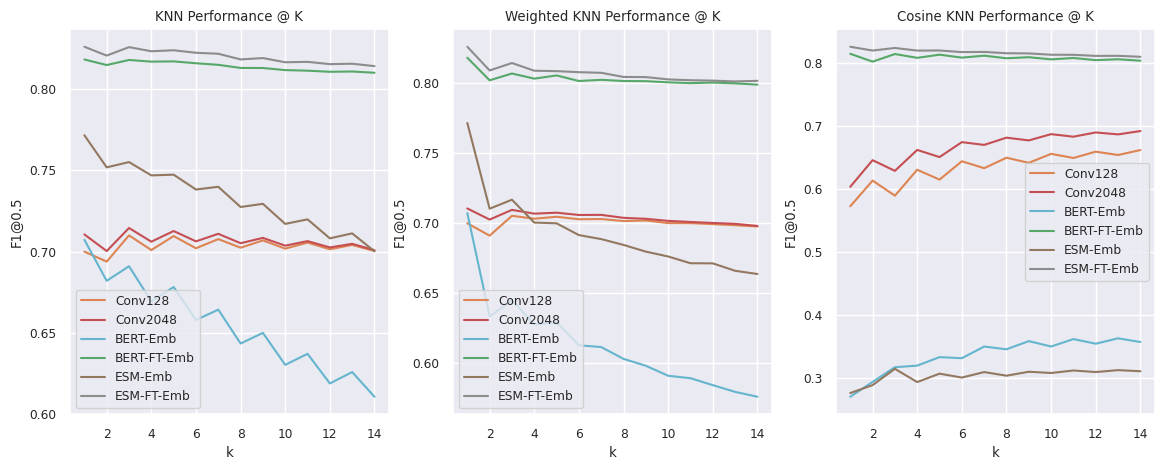

In [10]:
import seaborn as sns
sns.set_theme()
sns.set(font_scale=0.8)
colors = sns.color_palette()

embedding_paths = ['conv128', 'conv2048', 'rostlab', 'finetune', 'pretrained_esm', 'esm_finetune']
model_labels = ['Conv128', 'Conv2048', 'BERT-Emb', 'BERT-FT-Emb', 'ESM-Emb', 'ESM-FT-Emb']
label_info = {ep: l for ep, l in zip(embedding_paths, model_labels)}

disp_info = {
    "BLAST": colors[0],
    "Conv128": colors[1],
    "Conv2048": colors[3],
    "BERT-Emb": colors[-1],
    "BERT-FT-Emb": colors[2],
    "ESM-Emb": colors[5],
    "ESM-FT-Emb": colors[7]
}

fig, axes = plt.subplots(1, 3, figsize=(14,5))
ax = axes[0]
ax.set_xlabel('k')
ax.set_ylabel('F1@0.5')
for ep, k_perf in knn_emb_stats.items():
    n = label_info[ep]
    ax.plot(np.arange(1, 15), k_perf, c=disp_info[n], label=f"{n}")
ax.legend()
ax.set_title('KNN Performance @ K')

ax = axes[1]
ax.set_xlabel('k')
ax.set_ylabel('F1@0.5')
for ep, k_perf in wknn_emb_stats.items():
    n = label_info[ep]
    ax.plot(np.arange(1, 15), k_perf, c=disp_info[n], label=f"{n}")
ax.legend()
ax.set_title('Weighted KNN Performance @ K')

ax = axes[2]
ax.set_xlabel('k')
ax.set_ylabel('F1@0.5')
for ep, k_perf in cos_knn_emb_stats.items():
    n = label_info[ep]
    ax.plot(np.arange(1, 15), k_perf, c=disp_info[n], label=f"{n}")
ax.legend()
ax.set_title('Cosine KNN Performance @ K')
fig.show()

In [14]:
cos_knn_emb_stats = {}
for ep, embs in emb_dict.items():
    te, ve, tee = embs
    train_ids, train_emb = te
    test_ids, test_emb = tee
    k_perf = []
    for k in range(1, 15):
        knn_preds = embedding_knn_cosine(train_emb, test_emb, train_labels, k=k) > 0.5
        p, r, f, support = precision_recall_fscore_support(test_labels, knn_preds, average='micro')
        k_perf.append(f)
    cos_knn_emb_stats[ep] = k_perf

wknn_emb_stats = {}
for ep, embs in emb_dict.items():
    te, ve, tee = embs
    train_ids, train_emb = te
    test_ids, test_emb = tee
    k_perf = []
    for k in range(1, 15):
        knn_preds = embedding_wknn(train_emb, test_emb, train_labels, k=k) > 0.5
        p, r, f, support = precision_recall_fscore_support(test_labels, knn_preds, average='micro')
        k_perf.append(f)
    wknn_emb_stats[ep] = k_perf

knn_emb_stats = {}
for ep, embs in emb_dict.items():
    te, ve, tee = embs
    train_ids, train_emb = te
    test_ids, test_emb = tee
    k_perf = []
    for k in range(1, 15):
        knn_preds = embedding_knn(train_emb, test_emb, train_labels, k=k) > 0.5
        p, r, f, support = precision_recall_fscore_support(test_labels, knn_preds, average='micro')
        k_perf.append(f)
    knn_emb_stats[ep] = k_perf

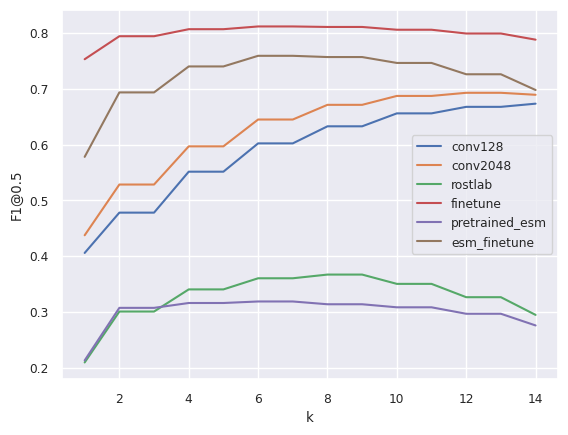

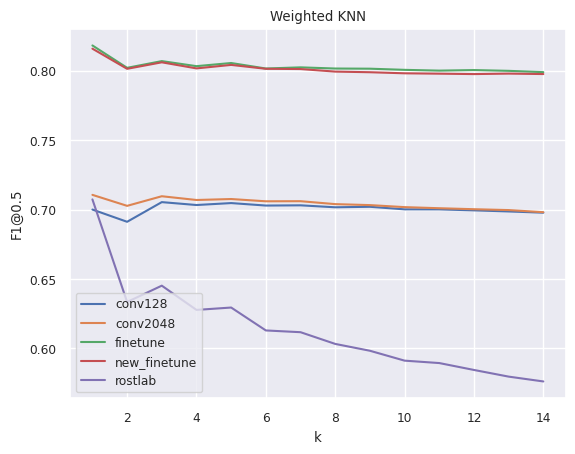

In [22]:

    
fig, ax = plt.subplots()
ax.set_xlabel('k')
ax.set_ylabel('F1@0.5')
for ep, k_perf in knn_emb_stats.items():
    ax.plot(np.arange(1, 15), k_perf, label=f"{ep}")
ax.set_title('Weighted KNN')
ax.legend()
fig.show()

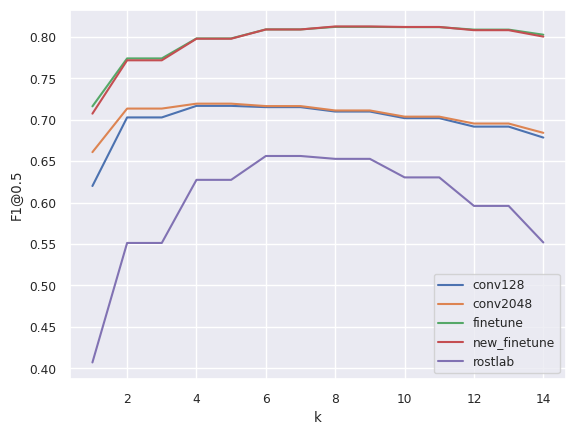

In [13]:
fig, ax = plt.subplots()
ax.set_xlabel('k')
ax.set_ylabel('F1@0.5')
for ep, k_perf in knn_emb_stats.items():
    ax.plot(np.arange(1, 15), k_perf, label=f"{ep}")
ax.legend()
fig.show()

In [ ]:
emb_stats = {}
for ep, embs in emb_dict.items():
    te, ve, tee = embs
    train_ids, train_emb = te
    test_ids, test_emb = tee
    knn_preds = csr_matrix(embedding_knn(train_emb, test_emb, train_labels, k=10))
    emb_stats[ep] = threshold_stats(test_labels, knn_preds, test_ia)

In [24]:
import seaborn as sns
sns.set_theme()
sns.set(font_scale=0.8)
colors = sns.color_palette()

(3,)


/tmp/ipykernel_3409191/2997059413.py:3: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([x[0], x[-1]], [y[0], y[-1]], s=3, c=kwargs['c'])


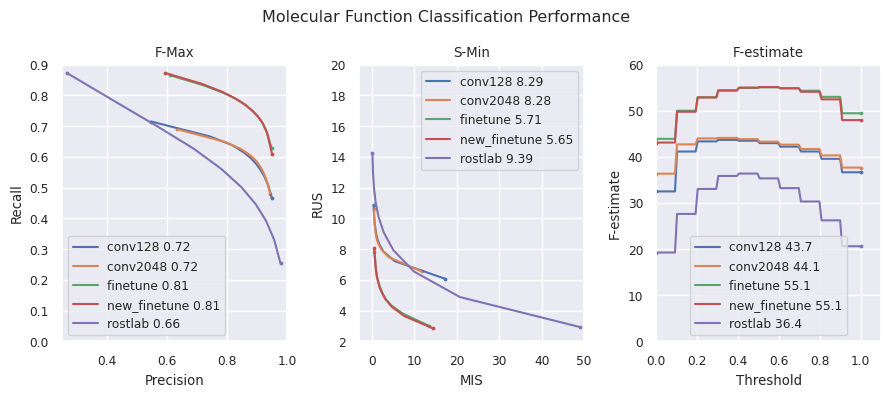

In [25]:
def plot_curve(ax, x, y, **kwargs):
    ax.plot(x, y, **kwargs)
    ax.scatter([x[0], x[-1]], [y[0], y[-1]], s=3, c=kwargs['c'])

fig, axes = plt.subplots(1, 3, figsize=(9, 4))
print(axes.shape)
fig.suptitle("Molecular Function Classification Performance")

base_models = ["BLAST", "Conv", "BERT-Emb", "BERT-FT", "Naive"]

i = 0
for model_name in emb_stats.keys():
    stats = emb_stats[model_name]
    c = colors[i]
    i += 1
    precs, recs, f_scores, rms, mis, rus, s_vals = stats
    plot_curve(axes[0], precs, recs, label=f"{model_name} {round(max(f_scores), 2)}", c=c)
    axes[0].set_xlabel("Precision")
    axes[0].set_ylabel("Recall")

    plot_curve(axes[1], mis, rus, label=f"{model_name} {round(min(s_vals), 2)}", c=c)
    axes[1].set_xlabel("MIS")
    axes[1].set_ylabel("RUS")

    plot_curve(axes[2], np.linspace(0, 1, len(rms)), rms, label=f"{model_name} {round(max(rms), 1)}", c=c)
    axes[2].set_xlabel("Threshold")
    axes[2].set_ylabel("F-estimate")

axes[0].set_xlim([0.25, 1])
axes[0].set_ylim([0, 0.9])
axes[1].set_xlim([-3, 50])
axes[1].set_ylim([2, 20])
axes[2].set_xlim([0, 1.1])
axes[2].set_ylim([0, 60])

axes[0].set_title("F-Max")
axes[1].set_title("S-Min")
axes[2].set_title("F-estimate")

axes[0].legend()
axes[1].legend()
axes[2].legend()

fig.tight_layout()
fig.show()

In [10]:
from go_metric.multilabel_knn import embedding_knn
train_labels = train_dataset.labels.toarray()
val_labels = val_dataset.labels.toarray()
rostlab_preds = csr_matrix(embedding_knn(train_embeddings, test_embeddings, train_labels, k=10))
emb_stats[ep] = threshold_stats(test_labels, rostlab_preds, test_ia)

True

In [ ]:
import pickle
with open("emb/rostlab_train_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    train_ids, train_embeddings = emb_dict['prot_id'], emb_dict['embedding']

with open("emb/rostlab_val_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    val_ids, val_embeddings = emb_dict['prot_id'], emb_dict['embedding']

with open("emb/rostlab_test_emb.pkl", "rb") as f:
    emb_dict = pickle.load(f)
    test_ids, test_embeddings = emb_dict['prot_id'], emb_dict['embedding']

from go_metric.multilabel_knn import embedding_knn
train_labels = train_dataset.labels.toarray()
val_labels = val_dataset.labels.toarray()
rostlab_preds = csr_matrix(embedding_knn(train_embeddings, test_embeddings, train_labels, k=10))
model_stats['BERT Embedding'] = threshold_stats(test_labels, rostlab_preds, test_ia)